In [8]:
import datetime as dt
import os

import numpy as np
import numpyro
import pandas as pd
import xarray as xr
from dateutil.relativedelta import relativedelta
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import (
    aes,
    geom_line,
    facet_grid,
    geom_ribbon,
    ggplot,
    scale_x_datetime,
    theme_bw,
    theme
)

from src.step1_data_loading.data_loading import load_data
from src.step2_preprocessing.preprocessing import XArrayScaler
from src.step3_modeling.ensemble import DefaultEnsemble
from src.step3_modeling.metrics import summarize
from src.step3_modeling.modeling import ModelBase
from src.step3_modeling.var_models import VAR
from src.step3_modeling.multivariate import LakeMVT
from src.utils import create_rnbs_snapshot

# device = "cuda"
device = "cpu"

os.environ["JAX_PLATFORM_NAME"] = device

numpyro.set_platform(device)
numpyro.set_host_device_count(4 if device == "cpu" else 1)

In [9]:
def preprocess_data(split_date, lake_data, validation_steps=12, num_years_ahead=1):
    x_scaler = XArrayScaler()
    y_scaler = XArrayScaler()

    lake_snapshot = create_rnbs_snapshot(rnbs_data=lake_data.sel(variable="rnbs"),
                                         covariates=lake_data.sel(variable=["runoff", "evap", "precip"]),
                                         split_date=split_date,
                                         validation_steps=validation_steps, sequential_validation=True,
                                         num_years_forward=num_years_ahead)
    lake_snapshot = lake_snapshot.apply_transformer(x_transformer=x_scaler, y_transformer=y_scaler)
    return lake_snapshot


lake_data = load_data(["rnbs", "precip", "evap", "runoff"]).dropna("Date").to_array().transpose("Date", "lake", ...)
scaled_lake_data = XArrayScaler().fit_transform(lake_data)
train_split = dt.datetime(1999, 12, 1)
snapshot = preprocess_data(train_split, lake_data)

snapshot.test_y

# original_values = snapshot.y_transformer.inverse_transform(snapshot.test_y)
# original_values

<xarray.DataArray (Date: 612, lake: 4)>
array([[ 2.86741567,  0.3540659 ,  1.28986629, -0.74853867],
       [ 0.99075354, -0.1893353 ,  0.11095037, -1.05499685],
       [ 2.07873869,  0.78969614,  0.99157355, -0.27421262],
       ...,
       [-0.73266244, -1.63509893, -1.19590738, -0.98114087],
       [-1.00922316, -1.27820438, -0.58328438, -0.99732445],
       [-0.47286299, -0.92079332, -0.28998121, -1.67894751]])
Coordinates:
  * Date      (Date) datetime64[ns] 1950-01-01 1950-02-01 ... 2000-12-01
  * lake      (lake) object 'eri' 'mic_hur' 'ont' 'sup'
    variable  <U4 'rnbs'

In [10]:
models = {
    # "VARX": VAR(lags={"y": 3, "runoff": 3, "precip": 6, "evap": 2}, num_chains=4, num_samples=1000, num_warmup=1000),
    # "VAR": VAR(lags={"y": 3}, num_chains=4, num_samples=1000, num_warmup=500),
    # "MVT": LakeMVT(),
    "Default": DefaultEnsemble()
}

In [11]:
def fit_model(fit_snapshot, model):
    model.fit(y=fit_snapshot.train_y, X=fit_snapshot.train_x)
    return model


def run_forecasts(start_date, fitted_model: ModelBase, num_years_ahead=10):
    rnbs = scaled_lake_data.sel(variable="rnbs").rename("true")
    all_dfs = []
    for i in range(12 * num_years_ahead + 1):
        new_split = start_date + relativedelta(months=i)
        new_snapshot = preprocess_data(new_split, lake_data, validation_steps=0, num_years_ahead=1)
        predictions = fitted_model.predict(X=new_snapshot.test_x, y=new_snapshot.test_y, forecast_steps=12)

        months_ahead = xr.DataArray(np.arange(1, 13), dims="Date", coords={"Date": predictions.indexes["Date"]},
                                    name="months_ahead")
        merged_ds = xr.merge([predictions, rnbs, months_ahead]).dropna("Date")
        comparison_df = merged_ds.to_dataframe(["Date", "lake", "value"]).reset_index(
            names=["Date", "lake", "value"]).pivot(index=["Date", "lake", "months_ahead", "true"], columns="value",
                                                   values="forecasts").reset_index()
        all_dfs.append(comparison_df)
    return pd.concat(all_dfs)


snapshot = preprocess_data(train_split, lake_data)
all_model_results = []
for name, model in models.items():
    fitted_model = fit_model(snapshot, model)
    predictions = run_forecasts(train_split, model).assign(model=name)
    all_model_results.append(predictions)

results_df = pd.concat(all_model_results)
results_df.head()

value,Date,lake,months_ahead,true,lower,mean,std,upper,model
0,2000-01-01,eri,1.0,-0.672800,-1.293129,-0.095628,0.698034,1.276609,Default
1,2000-01-01,mic_hur,1.0,-0.997913,-1.295564,-0.490981,0.480505,0.341894,Default
2,2000-01-01,ont,1.0,-0.531159,-1.535737,-1.035405,0.319011,-0.322557,Default
3,2000-01-01,sup,1.0,-1.102221,-0.888542,0.158457,0.804986,1.915436,Default
4,2000-02-01,eri,2.0,0.164472,-1.080510,0.005199,0.629745,1.332632,Default


In [12]:
results_df.groupby(["months_ahead", "model"]).apply(summarize, include_groups=False)

,,rmse,variance,bias,coverage,interval_len,crps,N
months_ahead,model,,,,,,,
1.0,Default,0.922854,0.851516,0.011942,0.747934,2.155240,0.547327,484.0
2.0,Default,0.925051,0.855567,0.012294,0.747934,2.155396,0.548616,484.0
3.0,Default,0.928210,0.861414,0.012609,0.745868,2.157786,0.551246,484.0
4.0,Default,0.933393,0.870782,0.021005,0.739669,2.159045,0.555044,484.0
5.0,Default,0.932792,0.869691,0.020267,0.739669,2.158189,0.554160,484.0
6.0,Default,0.934061,0.872111,0.018935,0.739669,2.154743,0.555461,484.0
7.0,Default,0.930926,0.865890,0.027072,0.741736,2.153092,0.552472,484.0
8.0,Default,0.933088,0.869804,0.029127,0.739669,2.152597,0.554681,484.0
9.0,Default,0.934224,0.871944,0.028829,0.739669,2.156632,0.555871,484.0


/Users/mcanearm/miniconda3/envs/noaa_mvp/lib/python3.11/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/mcanearm/miniconda3/envs/noaa_mvp/lib/python3.11/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/mcanearm/miniconda3/envs/noaa_mvp/lib/python3.11/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/mcanea

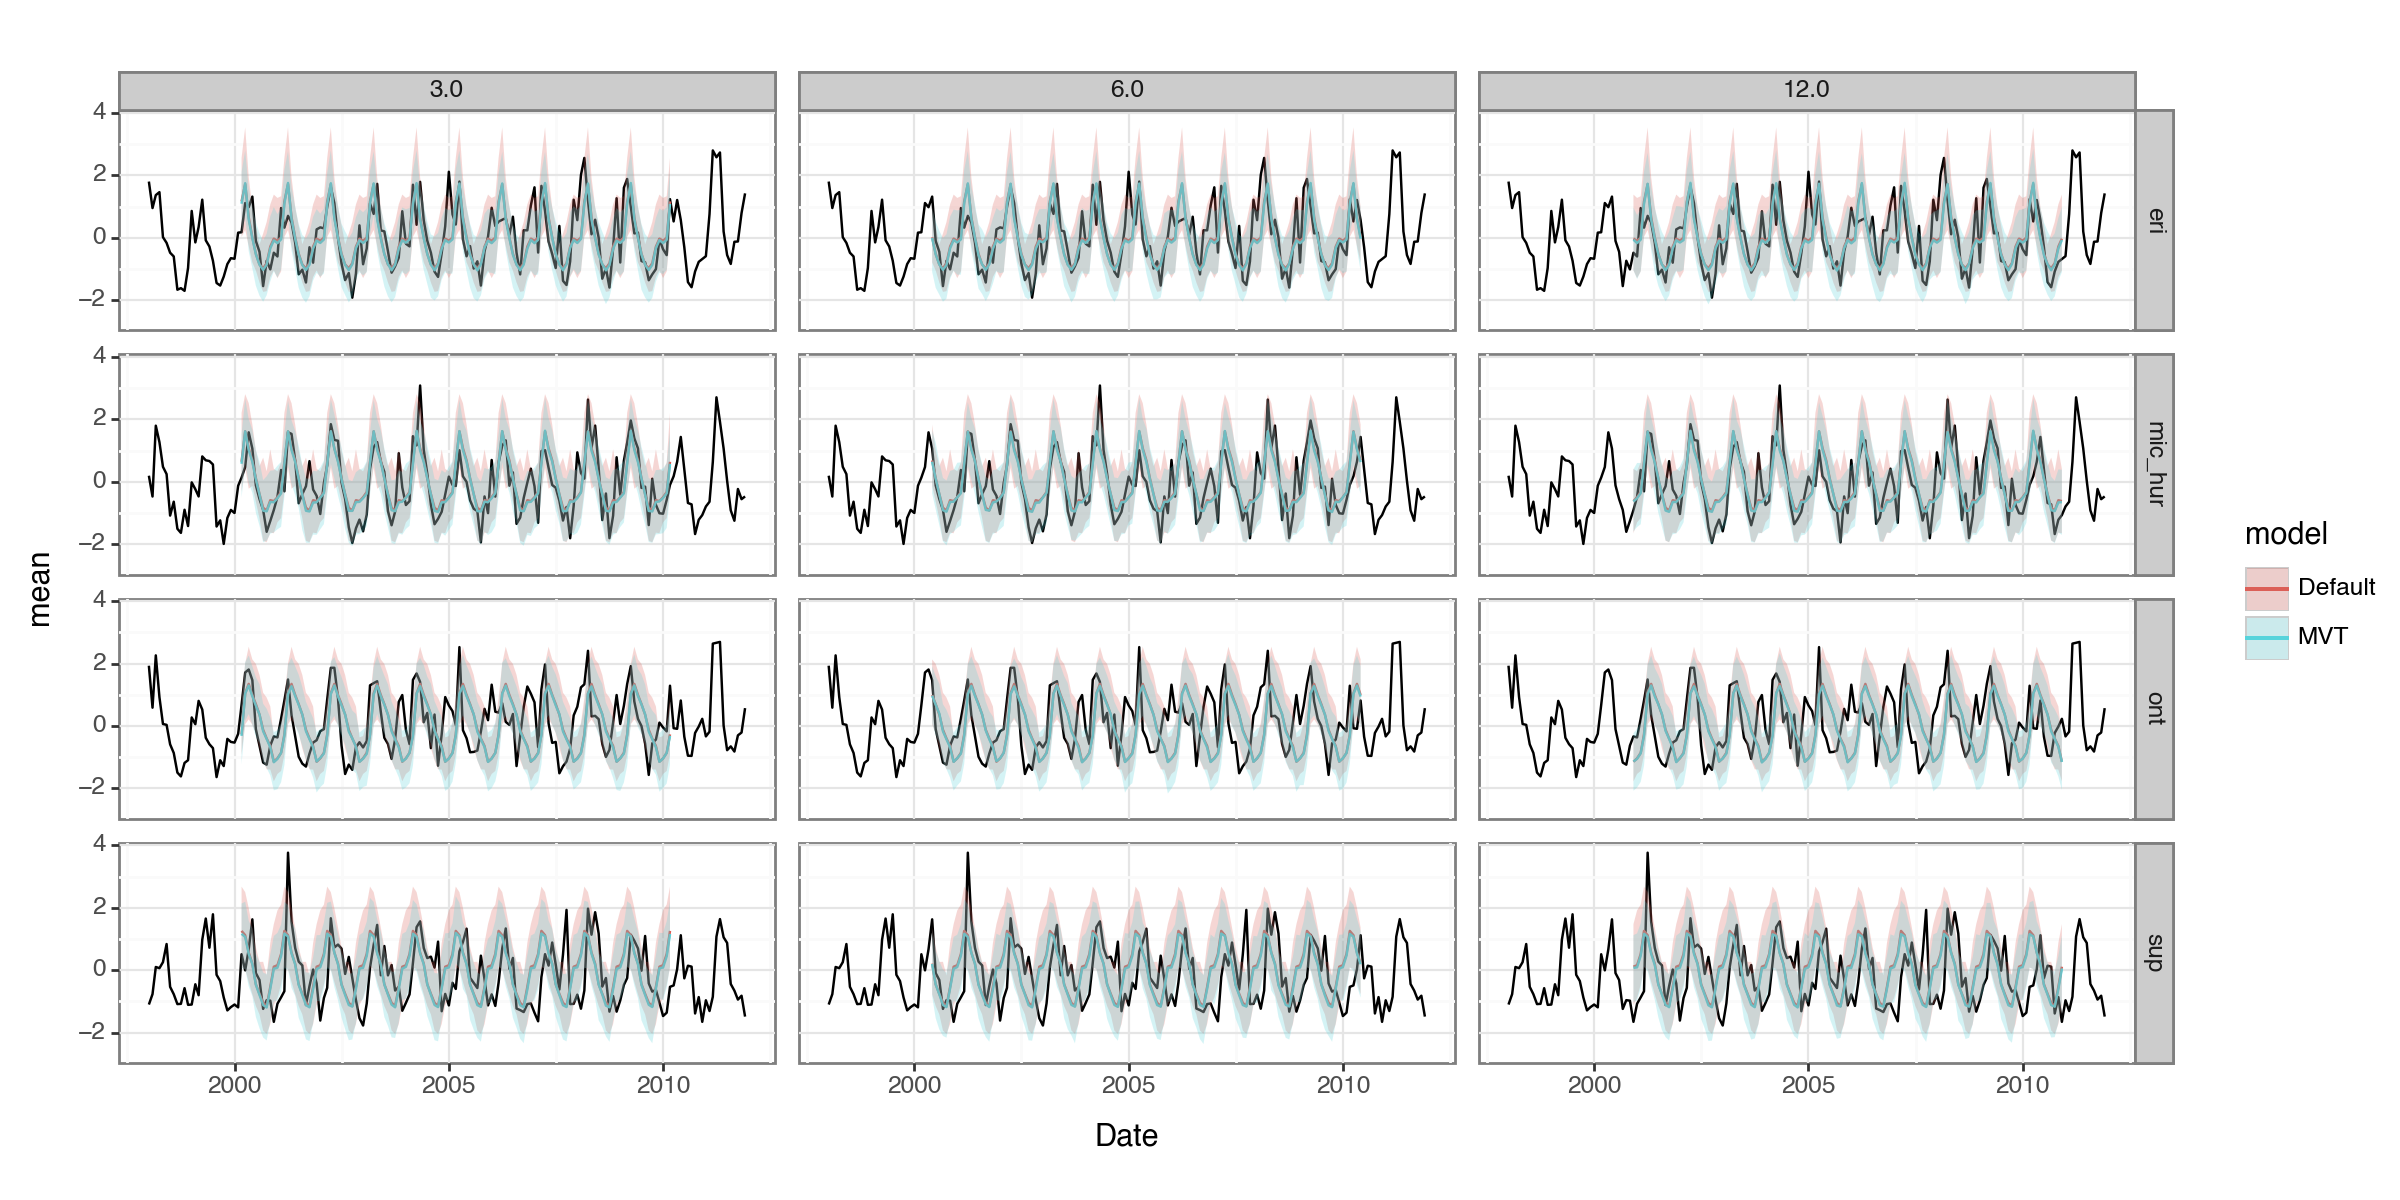

<Figure Size: (1200 x 600)>

In [6]:
og = scaled_lake_data.sel(variable="rnbs").to_dataframe(name="rnbs").reset_index().drop({"variable"}, axis=1)
result_subset = results_df[results_df["months_ahead"].isin([3, 6, 12])]

(
        ggplot(data=result_subset, mapping=aes(x="Date", y="mean", fill="model"))
        + geom_line(data=og, mapping=aes(x="Date", y="rnbs"), inherit_aes=False)
        + geom_line(mapping=aes(x="Date", y="mean", color="model"))
        + facet_grid("lake~months_ahead")
        + scale_x_datetime(
    limits=[results_df.Date.min() - relativedelta(years=2), results_df.Date.max() + relativedelta(years=1)],
    labels=date_format(fmt="%Y"), breaks=date_breaks("5 year"))
        + geom_ribbon(
    mapping=aes(x="Date", ymin="lower", ymax="upper"),
    alpha=0.25,
)
        + theme_bw()
        + theme(figure_size=(12, 6))
)
